DEBUG: Registros encontrados en JSON: 20714
DEBUG: Registros válidos para analizar: 20714


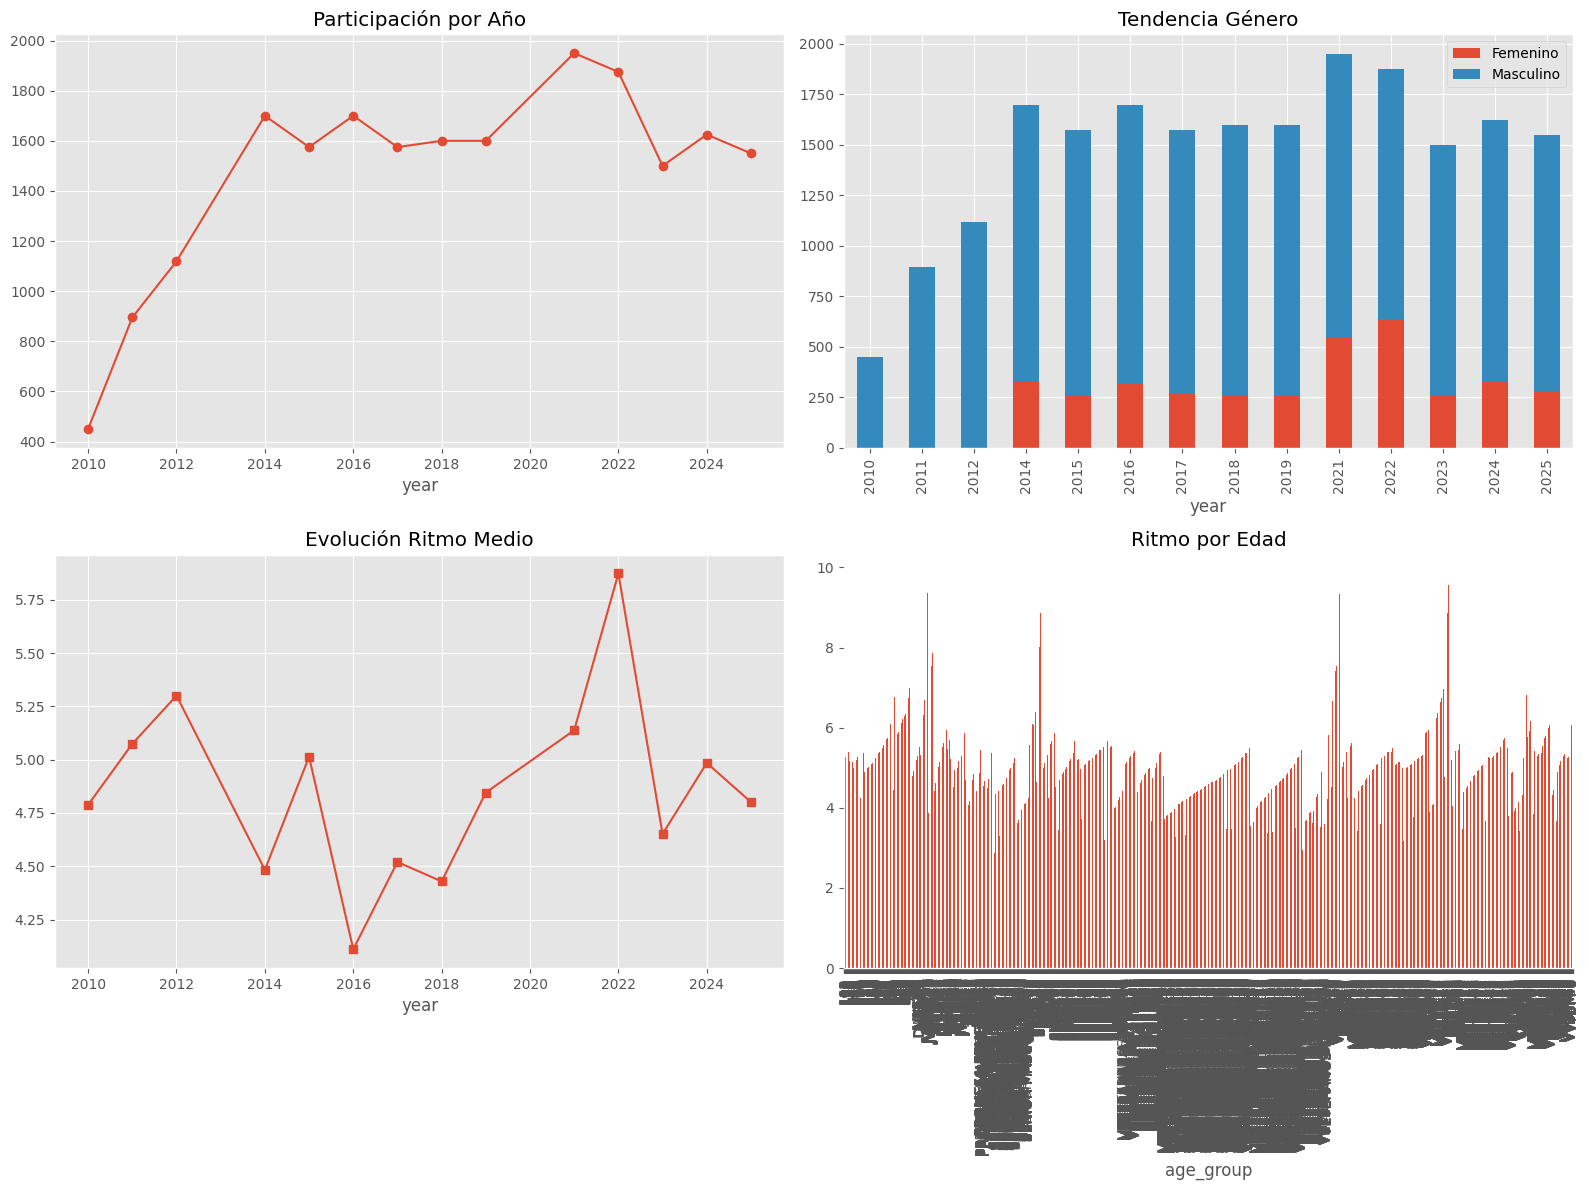


--- TOP 10 CORREDORES ---
                                   Ritmo  Carreras
runner_name                                       
LUIS PÉREZ VARELA            2:54 min/km         5
ANXO CASTRO VARELA           2:54 min/km         2
ALBERTO CASTIÑEIRA FIGUEROA  2:54 min/km         4
ALBERTO MORIS VIEITES        2:58 min/km         2
ABDELAZIZ FATIHI CHHIMA      2:59 min/km         3
ALVARO PRESEDO FRAGUÍO       2:59 min/km         4
DIEGO CRESPO NAYA            2:60 min/km         3
MARCOS ANTONIO SEIJO BUJÍA   3:01 min/km         2
FERNANDO DÍEZ GOMEZ          3:02 min/km         4
RAMON SERANTES GOMEZ         3:02 min/km         2


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

# --- UTILIDADES ---
def time_to_seconds(t_str):
    try:
        if pd.isna(t_str) or str(t_str).strip() == "": return None
        # Si pandas ya lo convirtió a datetime/time por error
        t_str = str(t_str).split()[-1] if ' ' in str(t_str) else str(t_str)
        parts = t_str.strip().split(':')
        if len(parts) == 3:
            h, m, s = map(int, parts)
            return h * 3600 + m * 60 + s
        return None
    except: return None

def format_pace(decimal_minutes):
    if pd.isna(decimal_minutes) or decimal_minutes <= 0: return "N/A"
    minutes = int(decimal_minutes)
    seconds = int(round((decimal_minutes - minutes) * 60))
    return f"{minutes}:{seconds:02} min/km"

# --- CARGA Y DIAGNÓSTICO ---
ruta_json = '/home/sebas/Race-Analysis-Platform/scrapy_project/edMongo.json'
df_raw = pd.read_json(ruta_json)

print(f"DEBUG: Registros encontrados en JSON: {len(df_raw)}")

# --- PROCESAMIENTO SEGURO ---
df = df_raw.copy()
df['finish_seconds'] = df['finish_time'].apply(time_to_seconds)
df['race_distance'] = pd.to_numeric(df['race_distance'], errors='coerce')
df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True, errors='coerce')

# Veto a la imaginación: Limpiamos solo lo crítico
df = df.dropna(subset=['finish_seconds', 'race_distance']).copy()

if df.empty:
    print("ERROR: El DataFrame quedó vacío tras limpiar 'finish_time' y 'race_distance'.")
    print("Verifica que los formatos en el JSON sean correctos (HH:MM:SS y números).")
    sys.exit()

df['year'] = df['fecha'].dt.year.fillna(0).astype(int)
df['pace_min_km'] = (df['finish_seconds'] / 60) / df['race_distance']
df['gender'] = df['gender'].astype(str).str.strip().str.capitalize()

print(f"DEBUG: Registros válidos para analizar: {len(df)}")

# --- VISUALIZACIÓN ---
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
ax = axes.flatten()

# A. Participación (Solo si hay años válidos)
if not df[df['year'] > 0].empty:
    df[df['year'] > 0].groupby('year').size().plot(ax=ax[0], kind='line', marker='o', title='Participación por Año')

# B. Género (Protección contra el TypeError)
gender_trends = df.groupby(['year', 'gender']).size().unstack(fill_value=0)
if not gender_trends.empty and (gender_trends.values > 0).any():
    gender_trends.columns = [str(c) for c in gender_trends.columns]
    gender_trends.plot(kind='bar', stacked=True, ax=ax[1], title='Tendencia Género')
else:
    ax[1].set_title("Género: Datos insuficientes")

# C. Ritmo Medio
df.groupby('year')['pace_min_km'].mean().plot(ax=ax[2], kind='line', marker='s', title='Evolución Ritmo Medio')

# D. Ritmo por Edad
df.groupby('age_group')['pace_min_km'].mean().sort_index().plot(ax=ax[3], kind='bar', title='Ritmo por Edad')

plt.tight_layout()
plt.show()

# --- TOP PERFORMERS ---
top_stats = df.groupby('runner_name').agg({'pace_min_km': 'mean', 'year': 'count'})

# Lógica de respaldo: si no hay "constantes", mostramos los mejores del día
top_filtered = top_stats[top_stats['year'] > 1]
if top_filtered.empty:
    print("\n[Nota] No hay corredores con múltiples carreras. Mostrando ranking general.")
    top_filtered = top_stats

top_10 = top_filtered.sort_values('pace_min_km').head(10).copy()
top_10['Ritmo'] = top_10['pace_min_km'].apply(format_pace)

print("\n--- TOP 10 CORREDORES ---")
print(top_10[['Ritmo', 'year']].rename(columns={'year': 'Carreras'}))